<a href="https://colab.research.google.com/github/bachaudhry/FastAI-22-23/blob/main/FastAI_2022_Linear_Models_and_Frameworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Building a Linear Model and Neural Network from Scratch - Review**

In [68]:
!pip install kaggle

In [69]:
# Setup
import os
import torch as t
import numpy as np
import pandas as pd
from pathlib import Path

# NB options
np.set_printoptions(linewidth=120)
t.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)
# Kaggle
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
# Using Kaggle API key and creating a path for credentials to be stored
# This step will need to be repeated thanks to Google's non persistent storage
creds = '{"username":"bachaudhry","key":"f8e0ee26f34cb0d3e4eccd774de62f63"}'
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
  cred_path.parent.mkdir(exist_ok=True)
  cred_path.write_text(creds)
  cred_path.chmod(0o600)


In [70]:
if iskaggle:
  path = Path('../input/titanic')
else:
  path = Path('titanic')
  if not path.exists():
    import zipfile, kaggle
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

## Loading and Cleaning the Data

In [71]:
df = pd.read_csv(path/'train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [73]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [74]:
df.describe(include=['object', 'number'])

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [75]:
# Get modes for all columnns for imputation
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [76]:
df.fillna(modes, inplace=True)

In [77]:
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

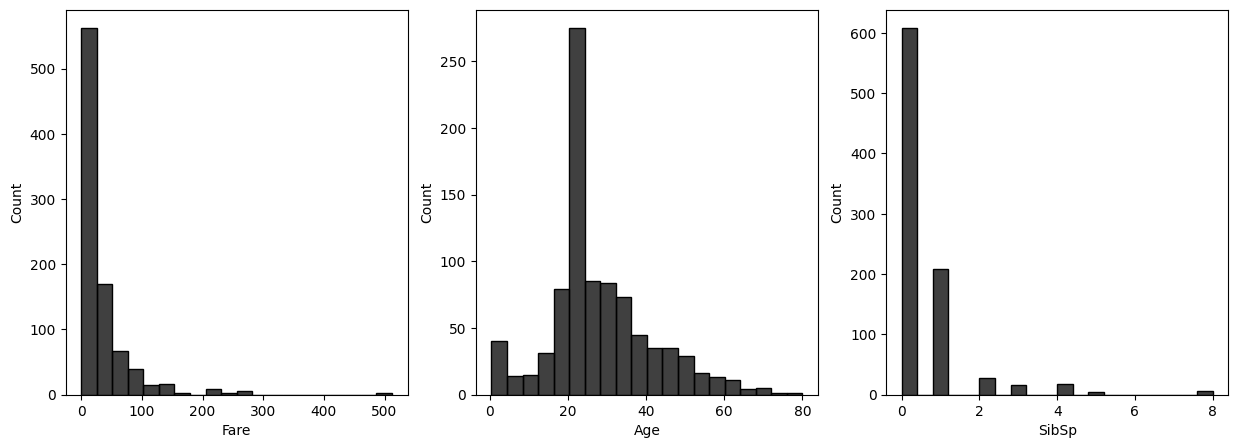

In [78]:
# Plotting key distributions
import seaborn as sns
import matplotlib.pyplot as plt
# Create grid fo subplots
fig, axes =  plt.subplots(nrows=1, ncols=3, figsize=(15,5))
#
sns.histplot(df, x='Fare', color='black', bins=20, ax=axes[0])
sns.histplot(df, x='Age',  color='black', bins=20, ax=axes[1])
sns.histplot(df, x='SibSp',color='black', bins=20, ax=axes[2])

plt.show();

Sticking with Jeremy's data augmentation steps from the lesson video, we'll take the log of the `Fare` column.

In order to deal with the zeros in the data, we'll add 1 to avoid getting `inf` results.

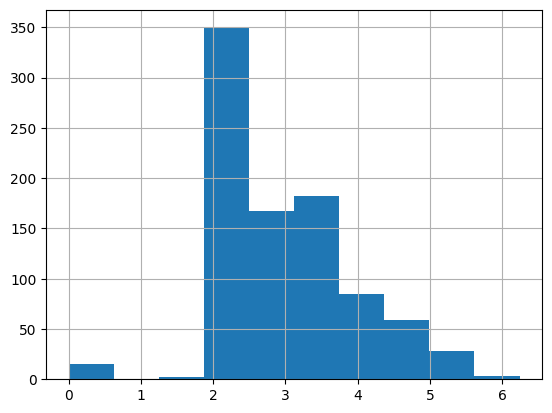

In [79]:
df['LogFare'] = np.log(df['Fare']+1)
df['LogFare'].hist();

Let's move on to the creation of dummy variables to handle strings and categoricals.

In [80]:
df = pd.get_dummies(df, columns=["Sex", "Pclass", "Embarked"], dtype='int')
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [81]:
# Checking the columns created by get_dummies()
added_cols = [col for col in df.columns if '_' in col]
df[added_cols].head()

,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,0,1,0,0,1,0,0,1
1,1,0,1,0,0,1,0,0
2,1,0,0,0,1,0,0,1
3,1,0,1,0,0,0,0,1
4,0,1,0,0,1,0,0,1


In [82]:
# Independent and dependent variables will now be stored as tensors
t_dep = t.tensor(df.Survived)

indep_cols = ['Age', 'SibSp', 'Parch', 'LogFare'] + added_cols
t_indep = t.tensor(df[indep_cols].values, dtype=t.float)
t_indep

tensor([[22.0000,  1.0000,  0.0000,  2.1102,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [38.0000,  1.0000,  0.0000,  4.2806,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [26.0000,  0.0000,  0.0000,  2.1889,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  1.0000,  0.0000,  3.9908,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  0.0000,  0.0000,  2.2028,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [24.0000,  0.0000,  0.0000,  2.2469,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000],
        [54.0000,  0.0000,  0.0000,  3.9677,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        ...,
        [25.0000,  0.0000,  0.0000,  2.0857,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [39.0000,  0.0000,  5.0000,  3.4054

In [83]:
t_indep.shape

torch.Size([891, 12])

## Setting up a Linear Model

In [84]:
t.manual_seed(442)
# For our linear model, we will need a coefficient for each column in t_indep
n_coeff = t_indep.shape[1]
# Picking random numbers b/w -0.5 and 0.5
coeffs = t.rand(n_coeff) - 0.5
coeffs

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625])

In [85]:
# Predictions will be calculated by multiplying each row by the coeffs and summing them up.
t_indep * coeffs

tensor([[-10.1838,   0.1386,   0.0000,  -0.4772,  -0.0000,  -0.3147,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-17.5902,   0.1386,   0.0000,  -0.9681,  -0.2632,  -0.0000,   0.4876,   0.0000,   0.0000,  -0.4392,   0.0000,   0.0000],
        [-12.0354,   0.0000,   0.0000,  -0.4950,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.1386,   0.0000,  -0.9025,  -0.2632,  -0.0000,   0.4876,   0.0000,   0.0000,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.0000,   0.0000,  -0.4982,  -0.0000,  -0.3147,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-11.1096,   0.0000,   0.0000,  -0.5081,  -0.0000,  -0.3147,   0.0000,   0.0000,   0.2799,  -0.0000,   0.2103,   0.0000],
        [-24.9966,   0.0000,   0.0000,  -0.8973,  -0.0000,  -0.3147,   0.4876,   0.0000,   0.0000,  -0.0000,   0.0000,   0.3625],
        ...,
        [-11.5725,   0.0000,   0.0000,  -0.4717,  -0.0000,  -0.3147,   0.0000

In [86]:
# Normalizing the data in all columns
vals, indices = t_indep.max(dim=0)
t_indep = t_indep / vals

In [87]:
# Multiplying again
t_indep * coeffs

tensor([[-0.1273,  0.0173,  0.0000, -0.0765, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2199,  0.0173,  0.0000, -0.1551, -0.2632, -0.0000,  0.4876,  0.0000,  0.0000, -0.4392,  0.0000,  0.0000],
        [-0.1504,  0.0000,  0.0000, -0.0793, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0173,  0.0000, -0.1446, -0.2632, -0.0000,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0000,  0.0000, -0.0798, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.1389,  0.0000,  0.0000, -0.0814, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.0000,  0.2103,  0.0000],
        [-0.3125,  0.0000,  0.0000, -0.1438, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        ...,
        [-0.1447,  0.0000,  0.0000, -0.0756, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2257,  0.0000,  0.2008, -0.1234

In [88]:
# Now that the data is normalized, creating predictions
preds = (t_indep * coeffs).sum(axis=1)
# Reviewing
preds[:15]

tensor([ 0.1412, -0.5725,  0.1494,  0.2571,  0.0453, -0.0448,  0.0792,  0.2961,  0.2128, -0.5770,  0.3093,  0.1311,  0.1321,  0.1942,
         0.2191])

In [89]:
# Creating a loss function for gradient descent
loss =  t.abs(preds - t_dep).mean()
loss

tensor(0.5200)

In [90]:
# Creating functions for the steps above
def calc_preds(coeffs, indeps):
  return (indeps *  coeffs).sum(axis=1)

def calc_loss(coeffs, indeps, deps):
  return t.abs(calc_preds(coeffs, indeps) - deps).mean()

## Creating a Single Gradient Descent Step

In [91]:
# Using PyTorch's requires_grad_() function on our coeffs
coeffs.requires_grad_()

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625], requires_grad=True)

In [92]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss

tensor(0.5200, grad_fn=<MeanBackward0>)

In [93]:
# Calculate gradients
loss.backward()

In [94]:
# Reviewing
coeffs.grad

tensor([-0.0483,  0.0118, -0.0041, -0.0804, -0.1975,  0.1111, -0.1235, -0.0426,  0.0797, -0.1886, -0.0617,  0.1639])

In [95]:
# Demonstrating how calling backward() adds gradients to the existing .grad attribute
loss =  calc_loss(coeffs, t_indep, t_dep)
loss.backward()
coeffs.grad

tensor([-0.0967,  0.0236, -0.0082, -0.1608, -0.3951,  0.2222, -0.2469, -0.0853,  0.1594, -0.3771, -0.1235,  0.3277])

In the cell below `a.sub_(b)` subtracts `b` from `a` as an in-place operation.

`a.zero_()` sets all elements of a tensor to zero.

In [96]:
# Resetting gradients back to zero
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
with t.no_grad():
  coeffs.sub_(coeffs.grad * 0.1)
  coeffs.grad.zero_()
  print(calc_loss(coeffs, t_indep, t_dep))

tensor(0.4809)


## Training the Linear Model.

We will use FastAI's RandomSplitter to split our data into training and validation.

In [97]:
from fastai.data.transforms import RandomSplitter

trn_split, val_split = RandomSplitter(seed=42)(df)

In [98]:
# Applying the indeces from the cell above to our independent and dependent variables
trn_indep, val_indep = t_indep[trn_split], t_indep[val_split]
trn_dep, val_dep = t_dep[trn_split], t_dep[val_split]
len(trn_indep), len(val_indep)

(713, 178)

We will create functions to:


*   Updating coeffs.
*   Doing one Gradient Descent step.
*   Initializing coeffs to random numbers.



In [99]:
def update_coeffs(coeffs, lr):
  coeffs.sub_(coeffs.grad * lr)
  coeffs.grad.zero_()

def one_epoch(coeffs, lr):
  loss = calc_loss(coeffs, trn_indep, trn_dep)
  loss.backward()
  with t.no_grad():
    update_coeffs(coeffs, lr)
  print(f"{loss: .3f}", end="; ")

def init_coeffs():
  return (t.rand(n_coeff) - 0.5).requires_grad_()

In [100]:
# Running the above to train our model
def train_model(epochs=30, lr=0.01):
  t.manual_seed(442)
  coeffs = init_coeffs()
  for i in range(epochs):
    one_epoch(coeffs, lr=lr)
  return coeffs

In [101]:
coeffs = train_model(20, lr=0.25)

 0.518;  0.485;  0.456;  0.427;  0.400;  0.374;  0.363;  0.344;  0.354;  0.307;  0.317;  0.313;  0.326;  0.287;  0.303;  0.292;  0.306;  0.295;  0.310;  0.291; 

In [102]:
# Displaying coefficients for each columnn
def show_coeffs ():
  return dict(zip(indep_cols, coeffs.requires_grad_(False)))

show_coeffs()

{'Age': tensor(-0.2599),
 'SibSp': tensor(0.0669),
 'Parch': tensor(0.2196),
 'LogFare': tensor(0.0427),
 'Sex_female': tensor(0.3251),
 'Sex_male': tensor(-0.4059),
 'Pclass_1': tensor(0.6482),
 'Pclass_2': tensor(0.5036),
 'Pclass_3': tensor(0.4264),
 'Embarked_C': tensor(0.1471),
 'Embarked_Q': tensor(0.2657),
 'Embarked_S': tensor(0.2181)}

## Measuring Accuracy

In [103]:
# The Titanic competition is scored on accuracy and not absolute error
# we will make this change and measure the performance of the model against the
# validation set.
preds = calc_preds(coeffs, val_indep)
# Assuming that passengers with a score of over 0.5 are predicted to survive
results = val_dep.bool() == (preds > 0.5)
results[:20]

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True, False, False, False,  True,  True, False,  True,  True,  True,
         True])

In [104]:
# The average of the above is...
results.float().mean()

tensor(0.7921)

In [105]:
# Adding the above to a function
def acc(coeffs):
  return (val_dep.bool() == (calc_preds(coeffs, val_indep) > 0.5)).float().mean()

acc(coeffs)

tensor(0.7921)

## Using Sigmoid Function

In [106]:
# We need to handle some predictions where probability of survival is either
# > 1 or < 0.
preds[:100]

tensor([1.0342, 0.2231, 0.1041, 0.2868, 0.2526, 0.2348, 0.9405, 0.9739, 0.3768, 0.8872, 0.1496, 0.1537, 0.2877, 0.9542, 0.1420, 0.3369,
        0.2719, 1.0247, 0.2116, 0.8844, 0.1756, 0.3011, 1.0709, 1.0011, 0.1879, 0.2387, 1.0284, 0.2816, 0.1989, 0.9541, 1.0796, 1.0591,
        0.1919, 0.1546, 1.0147, 1.0935, 0.3320, 1.0715, 0.1757, 0.9117, 0.2708, 0.1757, 0.2930, 1.0462, 0.1887, 1.0448, 0.1819, 0.2235,
        0.2225, 0.9126, 0.4126, 0.3509, 0.3398, 0.1717, 0.2480, 0.2285, 0.2231, 0.1492, 0.1855, 0.1655, 0.3149, 0.2060, 0.2240, 0.1854,
        0.9347, 0.4586, 0.2559, 0.1340, 0.2205, 0.9189, 0.1691, 0.9130, 0.2318, 0.1767, 0.4049, 0.2015, 0.1757, 0.3761, 0.2721, 0.1821,
        0.3911, 1.1802, 0.1789, 0.1751, 0.9011, 0.2708, 0.3715, 1.2603, 0.9152, 0.2591, 0.1500, 0.1757, 1.0549, 0.0846, 0.9701, 0.1459,
        0.1889, 0.9778, 0.9606, 0.2385])

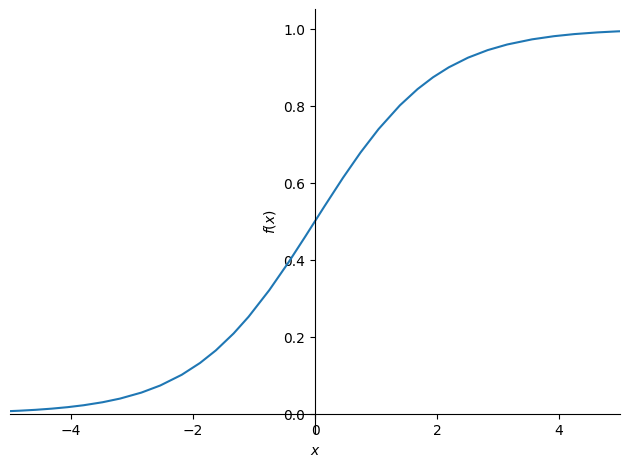

In [107]:
# Just to review what a Sigmoid does...
import sympy
sympy.plot("1 / (1 + exp(-x))", xlim=(-5, 5));

In [108]:
# Using PyTorch to define that function for us
def calc_preds(coeffs, indeps):
  return t.sigmoid((indeps * coeffs).sum(axis=1))

In [109]:
# Testing the updated prediction function by viewing our loss
# The lr is obviously, and greatly, exaggerated
coeffs = train_model(lr=100)

 0.503;  0.326;  0.294;  0.207;  0.201;  0.199;  0.198;  0.197;  0.196;  0.196;  0.196;  0.195;  0.195;  0.195;  0.195;  0.195;  0.195;  0.195;  0.194;  0.194;  0.194;  0.194;  0.194;  0.194;  0.194;  0.194;  0.194;  0.194;  0.194;  0.194; 

In [110]:
# Checking accuracy
acc(coeffs)

tensor(0.8258)

In [111]:
# Checking coeffs
show_coeffs()

{'Age': tensor(-1.5097),
 'SibSp': tensor(-1.1564),
 'Parch': tensor(-0.4253),
 'LogFare': tensor(0.2456),
 'Sex_female': tensor(8.4482),
 'Sex_male': tensor(-10.3873),
 'Pclass_1': tensor(3.8377),
 'Pclass_2': tensor(2.1304),
 'Pclass_3': tensor(-6.2481),
 'Embarked_C': tensor(1.4744),
 'Embarked_Q': tensor(2.1067),
 'Embarked_S': tensor(-4.8086)}

## Using Matrix Products

We can clean up the steps in the previous section by using matrix-vector products. This make calculations much more performant as we update our key functions as well.

In [112]:
val_indep @ coeffs

tensor([ 12.3344, -14.8963, -15.5310, -13.2355, -13.4334, -13.7300,   3.6332,   5.3455, -22.1751,   3.1302, -21.9617, -15.7196, -21.6367,
          3.9399, -22.0063, -12.0769, -12.4543,   5.3571, -13.6718,  -3.1041, -21.8109, -12.2845,  12.9945,   4.7428, -21.7393, -14.9992,
         -2.7445, -12.3977, -21.6755,   3.9393,   5.3925,  -3.6226, -21.7165, -21.9329,  12.2212,  -3.2294, -12.1052,  13.4747, -21.8102,
         -3.1386, -13.3279, -21.8102, -13.7664,  13.3275, -21.7347,  -3.5907, -21.7752, -21.9191, -14.9000,  -2.9406,  -5.3848, -22.3260,
        -22.1969, -21.8337, -13.4600, -13.5733, -14.8962, -22.1574, -21.7536, -21.8701,  -5.5092, -21.8272, -12.7328, -21.7541,   4.9249,
        -11.6538, -13.4146, -22.0530, -15.3886,   5.0261, -21.8486,   3.1896, -13.5544, -21.8043, -11.6815, -21.6604, -21.8102, -12.0423,
        -13.3202, -13.8433, -13.2992,  13.1525, -21.7920, -21.8138,   4.9226,  -7.3930,  -5.3745,   7.1156,  11.5067, -13.3957, -21.9598,
        -21.8102,  13.3782, -15.64

In [113]:
def calc_preds(coeffs, indeps):
  return t.sigmoid(indeps @ coeffs)

def init_coeffs():
  return (t.rand(n_coeff, 1) * 0.1).requires_grad_()

In [114]:
# Turning our dependent variables into columnn vectors by indexing the column
# dimension as None.
trn_dep = trn_dep[:, None]
val_dep = val_dep[:, None]

In [115]:
trn_dep.shape, val_dep.shape

(torch.Size([713, 1]), torch.Size([178, 1]))

In [116]:
coeffs = train_model(lr=100)

 0.512;  0.323;  0.290;  0.205;  0.200;  0.198;  0.197;  0.197;  0.196;  0.196;  0.196;  0.195;  0.195;  0.195;  0.195;  0.195;  0.195;  0.194;  0.194;  0.194;  0.194;  0.194;  0.194;  0.194;  0.194;  0.194;  0.194;  0.194;  0.194;  0.194; 

## Implementing a Neural Network

The following steps will be involved in creating a basic Neural Network:

1. Create coefficients for each layer of the NN.
2. For the first step, our coefficients will take `n_coeffs` as inputs and create `n_hidden` outputs. Hence, our matrix will be the size of `n_coeffs` by `n_hidden`.
3. The coefficients will be divided by `n_hidden` to retain similar magnitudes of numbers (normalize) when we begin summing up as we move throught each layer.
4. For the second layer, we will take `n_hidden` inputs to create a single output - so we will need a `n_hidden` by 1 matrix. This layer will also need a constant term.

In [117]:
def init_coeffs(n_hidden=20):
  layer1 = (t.rand(n_coeff, n_hidden) - 0.5) / n_hidden
  layer2 = t.rand(n_hidden, 1) - 0.3
  const = t.rand(1)[0]
  return layer1.requires_grad_(), layer2.requires_grad_(), const.requires_grad_()

In [118]:
# Creating NN
import torch.nn.functional as F

def calc_preds(coeffs, indeps):
  l1, l2, const = coeffs
  # Matrix products
  # First layer is passed to F.relu i.e. non-linearity
  res = F.relu(indeps @ l1)
  # Now with the result of the first layer
  res = res @ l2 + const
  # Finally, we will pass through a sigmoid
  return t.sigmoid(res)

In [119]:
# Given we have more than one set of coefficients, we will need to loop through
# them for updating
def update_coeffs(coeffs, lr):
  for layer in coeffs:
    layer.sub_(layer.grad * lr)
    layer.grad.zero_()

In [122]:
# Training
coeffs = train_model(lr=2.0)

 0.544;  0.529;  0.510;  0.481;  0.445;  0.398;  0.348;  0.308;  0.281;  0.264;  0.252;  0.244;  0.238;  0.233;  0.229;  0.227;  0.224;  0.223;  0.221;  0.219;  0.218;  0.217;  0.216;  0.215;  0.214;  0.213;  0.212;  0.211;  0.210;  0.210; 

In [123]:
acc(coeffs)

tensor(0.8258)

## From NN to Deep Learning

The simple NN above can be modified to add more matrix multiplications.

In [134]:
# Creating additional coefficients for each layer.
def init_coeffs():
  hiddens = [10, 10]
  sizes = [n_coeff] + hiddens + [1]
  n = len(sizes)
  layers =  [(t.rand(sizes[i], sizes[i + 1]) - 0.3) / sizes[i + 1] * 4 for i in range(n - 1)]
  consts = [(t.rand(1)[0] - 0.5) * 0.1 for i in range(n-1)]
  for l in layers + consts:
    l.requires_grad_()
  return layers, consts

In [135]:
def calc_preds(coeffs, indeps):
  layers, consts = coeffs
  n = len(layers)
  res = indeps
  for i, l in enumerate(layers):
    res = res @ l + consts[i]
    if i != n-1:
      res = F.relu(res)
  return t.sigmoid(res)

In [138]:
# We will also need to update to the coeff updating function
# Since layers and consts are seperated now.
def update_coeffs(coeffs, lr):
  layers, consts = coeffs
  for layer in layers + consts:
    layer.sub_(layer.grad * lr)
    layer.grad.zero_()

In [139]:
coeffs = train_model(lr = 4)

 0.514;  0.483;  0.469;  0.457;  0.446;  0.437;  0.429;  0.423;  0.418;  0.411;  0.376;  0.370;  0.364;  0.358;  0.348;  0.310;  0.227;  0.208;  0.209;  0.220;  0.205;  0.204;  0.211;  0.197;  0.196;  0.195;  0.194;  0.194;  0.194;  0.194; 

In [140]:
acc(coeffs)

tensor(0.8258)